In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import emoji, string
import nltk
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from nltk.corpus import stopwords
nltk.download('stopwords')

df = pd.read_csv('DataSet.csv')
# Set pandas option to display all columns
pd.set_option('display.max_columns', None)

df.shape

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\skypo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(17880, 18)

In [17]:
display(df)

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,in_balanced_dataset
0,Marketing Intern,"US, NY, New York",Marketing,NaN,"<h3>We're Food52, and we've created a groundbr...","<p>Food52, a fast-growing, James Beard Award-w...",<ul>\r\n<li>Experience with content management...,NaN,f,t,f,Other,Internship,NaN,NaN,Marketing,f,f
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"<h3>90 Seconds, the worlds Cloud Video Product...",<p>Organised - Focused - Vibrant - Awesome!<br...,<p><b>What we expect from you:</b></p>\r\n<p>Y...,<h3><b>What you will get from us</b></h3>\r\n<...,f,t,f,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,f,f
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,<h3></h3>\r\n<p>Valor Services provides Workfo...,"<p>Our client, located in Houston, is actively...",<ul>\r\n<li>Implement pre-commissioning and co...,NaN,f,t,f,NaN,NaN,NaN,NaN,NaN,f,f
3,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,<p>Our passion for improving quality of life t...,<p><b>THE COMPANY: ESRI – Environmental System...,<ul>\r\n<li>\r\n<b>EDUCATION: </b>Bachelor’s o...,<p>Our culture is anything but corporate—we ha...,f,t,f,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,f,f
4,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,<p>SpotSource Solutions LLC is a Global Human ...,<p><b>JOB TITLE:</b> Itemization Review Manage...,<p><b>QUALIFICATIONS:</b></p>\r\n<ul>\r\n<li>R...,<p>Full Benefits Offered</p>,f,t,t,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,f,f
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,Account Director - Distribution,"CA, ON, Toronto",Sales,NaN,<p>Vend is looking for some awesome new talent...,<p>Just in case this is the first time you’ve ...,<p>To ace this role you:</p>\r\n<ul>\r\n<li>Wi...,<p><b>What can you expect from us?</b></p>\r\n...,f,t,t,Full-time,Mid-Senior level,NaN,Computer Software,Sales,f,f
17876,Payroll Accountant,"US, PA, Philadelphia",Accounting,NaN,<p>WebLinc is the e-commerce platform and serv...,<p></p>\r\n<p>The Payroll Accountant will focu...,<p></p>\r\n<p>- B.A. or B.S. in Accounting</p>...,<p></p>\r\n<h3>Health &amp; Wellness</h3>\r\n<...,f,t,t,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,f,f
17877,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",NaN,NaN,<p>We Provide Full Time Permanent Positions fo...,<p>Experienced Project Cost Control Staff Engi...,<ul>\r\n<li>At least 12 years professional exp...,NaN,f,f,f,Full-time,NaN,NaN,NaN,NaN,f,f
17878,Graphic Designer,"NG, LA, Lagos",NaN,NaN,NaN,<p>Nemsia Studios is looking for an experience...,<p>1. Must be fluent in the latest versions of...,<p>Competitive salary (compensation will be ba...,f,f,t,Contract,Not Applicable,Professional,Graphic Design,Design,f,f


In [18]:
unique_locations = df['location'].nunique()
print(f"Number of unique values in 'location': {unique_locations}")

Number of unique values in 'location': 3105


## Exploratory Data Analysis

In [19]:
# Display the first few rows of the dataset
print("First 5 rows of the dataset:")
print(df.head())


First 5 rows of the dataset:
                                       title            location department  \
0                           Marketing Intern    US, NY, New York  Marketing   
1  Customer Service - Cloud Video Production      NZ, , Auckland    Success   
2    Commissioning Machinery Assistant (CMA)       US, IA, Wever        NaN   
3          Account Executive - Washington DC  US, DC, Washington      Sales   
4                        Bill Review Manager  US, FL, Fort Worth        NaN   

  salary_range                                    company_profile  \
0          NaN  <h3>We're Food52, and we've created a groundbr...   
1          NaN  <h3>90 Seconds, the worlds Cloud Video Product...   
2          NaN  <h3></h3>\r\n<p>Valor Services provides Workfo...   
3          NaN  <p>Our passion for improving quality of life t...   
4          NaN  <p>SpotSource Solutions LLC is a Global Human ...   

                                         description  \
0  <p>Food52, a fast-grow

In [20]:
# Check for basic information about the dataset
print("\nDataset Info:")
df.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                17880 non-null  object
 1   location             17534 non-null  object
 2   department           6333 non-null   object
 3   salary_range         2868 non-null   object
 4   company_profile      14572 non-null  object
 5   description          17880 non-null  object
 6   requirements         15191 non-null  object
 7   benefits             10684 non-null  object
 8   telecommuting        17880 non-null  object
 9   has_company_logo     17880 non-null  object
 10  has_questions        17880 non-null  object
 11  employment_type      14409 non-null  object
 12  required_experience  10830 non-null  object
 13  required_education   9775 non-null   object
 14  industry             12977 non-null  object
 15  function             11425 non-null  o

In [21]:
# Summary statistics for numerical columns
print("\nSummary Statistics:")
print(df.describe())


Summary Statistics:
                          title         location department salary_range  \
count                     17880            17534       6333         2868   
unique                    11231             3105       1337          874   
top     English Teacher Abroad   GB, LND, London      Sales          0-0   
freq                        311              718        551          142   

                                          company_profile  \
count                                               14572   
unique                                               1710   
top     <p>We help teachers get safe &amp; secure jobs...   
freq                                                  726   

                                              description  \
count                                               17880   
unique                                              15095   
top     <p>Play with kids, get paid for it </p>\r\n<p>...   
freq                                            

In [22]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                0
requirements            2689
benefits                7196
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
in_balanced_dataset        0
dtype: int64


In [23]:
# Check for duplicate rows
print("\nNumber of duplicate rows:")
print(df.duplicated().sum())


Number of duplicate rows:
235


In [24]:
# # Check the distribution of categorical columns
# print("\nCategorical Column Distributions:")
# categorical_cols = df.select_dtypes(include=['object', 'category']).columns
# for col in categorical_cols:
#     print(f"\nValue Counts for {col}:")
#     print(df[col].value_counts())
break

SyntaxError: 'break' outside loop (2864654861.py, line 7)

## Data Cleaning

In [ ]:
df.drop_duplicates(subset=['title','location', 'department' , 'salary_range', 'company_profile', 'description', 'requirements', 'benefits','telecommuting', 'has_company_logo', 'has_questions', 'employment_type', 'required_experience', 'required_education', 'industry', 'function', 'fraudulent'], keep='first', inplace=True)
df.shape

(17632, 18)

## Feature Engineering

In [ ]:
## TEXT PREPROCESSING FOR TEXTUAL COLUMNS

# Feature 1: COMBINING TEXTUAL COLUMNS INTO 1 COMBINED TEXT COLUMN

def clean_text_features(text):
    try:
        if pd.isnull(text):
            return ""

        # Remove HTML tags
        text = re.sub(r'<[^>]*>', '', text)

        # Convert to lowercase
        text = text.lower()

        # Remove non-alphanumeric characters (except specified punctuation)
        text = re.sub(r'[^\w\s.,:;!?\'"-]', '', text)

        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))

        # Remove emojis
        #text = emoji.replace_emoji(text, replace="")

        # Remove stopwords
        stop_words = set(stopwords.words("english"))
        words = text.split()
        filtered_words = [word for word in words if word not in stop_words]
        text = " ".join(filtered_words)

        return text

    except Exception as e:
        print(f"Error cleaning text: {e}")
        return ""


text_columns = ['title', 'benefits', 'description', 'requirements', 'company_profile']

for col in text_columns:
    df[col] = df[col].apply(clean_text_features)

df['combined_text_data'] = (
    df['title'] + ' ' +
    df['description'] + ' ' +
    df['requirements'] + ' ' +
    df['company_profile'] + ' ' +
    df['benefits']
)

# Feature 2: Since there are too many categories for location (3106) hence we decided to perform dimensionality reduction and just limit to the country and perform one-hot-encoding on country column
df['location'] = df['location'].fillna(",,")
df['country']=df['location'].apply(lambda x: x.split(",")[0])

# Dimensionality reduction
unique_locations = df['location'].nunique()
print(f"Number of unique values in 'location': {unique_locations}")

unique_country = df['country'].nunique()
print(f"Number of unique values in 'country': {unique_country}")


## Feature 3: feature engineering new numerical columns based on salary range column

df[['salary_lower', 'salary_upper']] = df['salary_range'].str.split('-', expand=True).astype(float)
df['salary_average'] = (df['salary_lower'] + df['salary_upper']) / 2
df['salary_range_diff'] = df['salary_upper'] - df['salary_lower']



Number of unique values in 'location': 3106
Number of unique values in 'country': 91


In [ ]:
display(df)

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,in_balanced_dataset,combined_text_data,country,salary_lower,salary_upper,salary_average,salary_range_diff
0,marketing intern,"US, NY, New York",Marketing,NaN,food52 weve created groundbreaking awardwinnin...,food52 fastgrowing james beard awardwinning on...,experience content management systems major pl...,,f,t,f,Other,Internship,NaN,NaN,Marketing,f,f,marketing intern food52 fastgrowing james bear...,US,NaN,NaN,NaN,NaN
1,customer service cloud video production,"NZ, , Auckland",Success,NaN,90 seconds worlds cloud video production servi...,organised focused vibrant awesomedo passion cu...,expect key responsibility communicate client 9...,get us part 90 seconds team gain experience wo...,f,t,f,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,f,f,customer service cloud video production organi...,NZ,NaN,NaN,NaN,NaN
2,commissioning machinery assistant cma,"US, IA, Wever",NaN,NaN,valor services provides workforce solutions me...,client located houston actively seeking experi...,implement precommissioning commissioning proce...,,f,t,f,NaN,NaN,NaN,NaN,NaN,f,f,commissioning machinery assistant cma client l...,US,NaN,NaN,NaN,NaN
3,account executive washington dc,"US, DC, Washington",Sales,NaN,passion improving quality life geography heart...,company esri environmental systems research in...,education bachelors masters gis business admin...,culture anything corporatewe collaborative cre...,f,t,f,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,f,f,account executive washington dc company esri e...,US,NaN,NaN,NaN,NaN
4,bill review manager,"US, FL, Fort Worth",NaN,NaN,spotsource solutions llc global human capital ...,job title itemization review manager location ...,qualifications rn license state texas diploma ...,full benefits offered,f,t,t,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,f,f,bill review manager job title itemization revi...,US,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,account director distribution,"CA, ON, Toronto",Sales,NaN,vend looking awesome new talent come join us y...,case first time youve visited website vend awa...,ace role eat comprehensive statements work bre...,expect us open culture openly share results in...,f,t,t,Full-time,Mid-Senior level,NaN,Computer Software,Sales,f,f,account director distribution case first time ...,CA,NaN,NaN,NaN,NaN
17876,payroll accountant,"US, PA, Philadelphia",Accounting,NaN,weblinc ecommerce platform services provider f...,payroll accountant focus primarily payroll fun...,ba bs accounting desire fun love genuine passi...,health amp wellness medical plan prescription ...,f,t,t,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,f,f,payroll accountant payroll accountant focus pr...,US,NaN,NaN,NaN,NaN
17877,project cost control staff engineer cost contr...,"US, TX, Houston",NaN,NaN,provide full time permanent positions many med...,experienced project cost control staff enginee...,least 12 years professional experience ability...,,f,f,f,Full-time,NaN,NaN,NaN,NaN,f,f,project cost control staff engineer cost contr...,US,NaN,NaN,NaN,NaN
17878,graphic designer,"NG, LA, Lagos",NaN,NaN,,nemsia studios looking experienced visualgraph...,1 must fluent latest versions corel amp adobe ...,competitive salary compensation based experien...,f,f,t,Contract,Not Applicable,Professional,Graphic Design,Design,f,f,graphic designer nemsia studios looking experi...,NG,NaN,NaN,NaN,NaN


In [ ]:
## encoding binary columns

binary_columns = ['telecommuting', 'has_company_logo', 'has_questions', 'fraudulent']

for column in binary_columns:
    if column in df.columns:
        df[column] = df[column].apply(lambda x: 1 if x == 't' else (0 if x == 'f' else None))

In [ ]:
display(df.shape)


(17632, 24)

In [ ]:
#One hot encoding for categorical columns

categorical_columns = ['country', 'department', 'employment_type', 'required_experience',
                       'required_education', 'industry', 'function']

df[categorical_columns] = df[categorical_columns].fillna('Unknown')
# Perform one-hot encoding on the specified columns
df = pd.get_dummies(df, columns=categorical_columns, prefix=categorical_columns, drop_first=False)

# Convert all resulting one-hot encoded columns to integers
for col in df.columns:
    if df[col].dtype == 'bool':
        df[col] = df[col].astype(int)

In [ ]:
display(df.shape)

(17632, 1643)

In [ ]:
# DROPPING RAW TEXTUAL COLUMNS THAT ARE UNUSED

columns_to_drop = ['title',
                    'description',
                    'requirements',
                    'company_profile',
                    'benefits',
                    'salary_range',
                    'location',
                    'in_balanced_dataset']

df.drop(columns_to_drop, axis = 1, inplace = True)



In [ ]:
display(df.shape)

(17632, 1635)

## Train Validation Test Split (Text, Categorical and Numerical columns)
Train-Test-Validation: 70-15-15

Standard scaling for numerical columns

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
X = df.drop('fraudulent', axis=1, inplace=False)
y = df['fraudulent']  # Target variable to predict

## splitting into training (70%) and remaining (30%)
X_train, X_rem, y_train, y_rem = train_test_split(X, y, test_size = 0.3, random_state=42)

## splitting remaining into test (15%) and validation (15%)
X_test, X_val, y_test, y_val = train_test_split(X_rem, y_rem, test_size = 0.5, random_state=42)

# Scaling numerical columnsx

columns_to_normalize = ['salary_lower', 'salary_upper', 'salary_average', 'salary_range_diff']
scaler = StandardScaler()
X_train[columns_to_normalize] = scaler.fit_transform(X_train[columns_to_normalize])
X_test[columns_to_normalize] = scaler.transform(X_test[columns_to_normalize])
X_val[columns_to_normalize] = scaler.transform(X_val[columns_to_normalize])

for dataset in [X_train, X_val, X_test]:
    display(dataset.shape)

(12342, 1634)

(2645, 1634)

(2645, 1634)

## Train Validation Test Split (Only categorical columns) (No Combined Cleaned Text + No numerical columns)


In [ ]:
X = df.drop('fraudulent', axis=1, inplace=False)
y = df['fraudulent']

columns_to_drop2 = ['combined_text_data', 'salary_lower', 'salary_upper', 'salary_average', 'salary_range_diff']
X_cat = X.drop(columns_to_drop2, axis = 1)

## splitting into training (70%) and remaining (30%)
X_train_cat, X_rem_cat, y_train_cat, y_rem_cat = train_test_split(X_cat, y, test_size = 0.3, random_state=42)

## splitting remaining into test (15%) and validation (15%)
X_test_cat, X_val_cat, y_test_cat, y_val_cat = train_test_split(X_rem_cat, y_rem_cat, test_size = 0.5, random_state=42)


for dataset in [X_train_cat, X_val_cat, X_test_cat]:
    display(dataset.shape)

(12342, 1629)

(2645, 1629)

(2645, 1629)

# Embeddings for textual data

In [ ]:
#Count Vectorizer Embedding
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(X_train['combined_text_data'])
X_train_count =  count_vect.transform(X_train['combined_text_data'])
X_val_count = count_vect.transform(X_val['combined_text_data'])
X_test_count = count_vect.transform(X_test['combined_text_data'])

#TFIDF Embedding
tfidf_vect = TfidfVectorizer()
tfidf_vect.fit(X_train['combined_text_data'])
X_train_tfidf = tfidf_vect.transform(X_train['combined_text_data'])
X_val_tfidf = tfidf_vect.transform(X_val['combined_text_data'])
X_test_tfidf = tfidf_vect.transform(X_test['combined_text_data'])

In [ ]:
display(X_train_count.shape)
display(X_val_count.shape)
display(X_test_count.shape)

(12342, 60186)

(2645, 60186)

(2645, 60186)

In [ ]:
display(X_train_tfidf.shape)
display(X_val_tfidf.shape)
display(X_test_tfidf.shape)

(12342, 60126)

(2645, 60126)

(2645, 60126)

In [ ]:

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression


## Machine Learning Models


# Evaluation of different models

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test, scoring='roc_auc'):
    """
    Function to train, cross-validate, and evaluate a model.

    Parameters:
        model: The machine learning model (e.g., LogisticRegression, RandomForestClassifier).
        X_train: Features for training.
        y_train: Labels for training.
        X_val: Features for validation.
        y_val: Labels for validation.
        X_test: Features for testing.
        y_test: Labels for testing.
        scoring: Metric for cross-validation (default is 'roc_auc').
    """
    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Cross-validation on training set
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=scoring)
    print(f"Cross-Validation {scoring.upper()} Scores: {cv_scores}")
    print(f"Cross-Validation Mean {scoring.upper()}: {cv_scores.mean():.4f}")

    # Evaluate on validation set
    val_pred_proba = model.predict_proba(X_val)[:, 1]
    val_auc = roc_auc_score(y_val, val_pred_proba)
    print(f"Validation AUC-ROC: {val_auc:.4f}")

    # Final evaluation on test set
    test_pred = model.predict(X_test)
    test_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_test, test_pred)
    # Extract individual elements
    TN, FP, FN, TP = conf_matrix.ravel()
    # Print the confusion matrix as a formatted table
    print("\nConfusion Matrix Table:")
    print(f"{'':<20} {'Predicted Negative':<20} {'Predicted Positive':<20}")
    print(f"{'Actual Negative':<20} {TN:<20} {FP:<20}")
    print(f"{'Actual Positive':<20} {FN:<20} {TP:<20}")
    print("")

    accuracy = accuracy_score(y_test, test_pred)
    precision = precision_score(y_test, test_pred)
    recall = recall_score(y_test, test_pred)
    f1 = f1_score(y_test, test_pred)
    auc_score = roc_auc_score(y_test, test_pred_proba)

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1 Score: {f1:.4f}")
    print(f"Test AUC-ROC: {auc_score:.4f}")

    # Calculate and plot the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, test_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Random Guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)', fontsize=12)
    plt.ylabel('True Positive Rate (TPR)', fontsize=12)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(alpha=0.3)
    plt.show()


In [ ]:
def evaluate_keras_nn_model(model, X_train, y_train, X_val, y_val, X_test, y_test, epochs=20, batch_size=32):
    """
    Function to train, cross-validate, and evaluate a Keras model.

    Parameters:
        model: The Keras model.
        X_train: Features for training.
        y_train: Labels for training.
        X_val: Features for validation.
        y_val: Labels for validation.
        X_test: Features for testing.
        y_test: Labels for testing.
        epochs: Number of training epochs.
        batch_size: Batch size for training.
    """
    # Train the model
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=1)

    # Evaluate on validation set
    val_pred_proba = model.predict(X_val).flatten()  # Keras `predict` for probabilities
    val_auc = roc_auc_score(y_val, val_pred_proba)
    print(f"Validation AUC-ROC: {val_auc:.4f}")

    # Final evaluation on test set
    test_pred_proba = model.predict(X_test).flatten()  # Probabilities
    test_pred = (test_pred_proba > 0.5).astype(int)  # Binary predictions

    # Metrics
    accuracy = accuracy_score(y_test, test_pred)
    precision = precision_score(y_test, test_pred)
    recall = recall_score(y_test, test_pred)
    f1 = f1_score(y_test, test_pred)
    auc_score = roc_auc_score(y_test, test_pred_proba)

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1 Score: {f1:.4f}")
    print(f"Test AUC-ROC: {auc_score:.4f}")

    # Plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, test_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Random Guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)', fontsize=12)
    plt.ylabel('True Positive Rate (TPR)', fontsize=12)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(alpha=0.3)
    plt.show()

# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
LogRmodel = LogisticRegression(max_iter= 3000)

#### Categorical variables only

Cross-Validation ROC_AUC Scores: [0.92833719 0.93427491 0.92957668 0.94685932 0.90303866]
Cross-Validation Mean ROC_AUC: 0.9284
Validation AUC-ROC: 0.9054

Confusion Matrix Table:
                     Predicted Negative   Predicted Positive  
Actual Negative      2515                 9                   
Actual Positive      82                   39                  

Test Accuracy: 0.9656
Test Precision: 0.8125
Test Recall: 0.3223
Test F1 Score: 0.4615
Test AUC-ROC: 0.9237


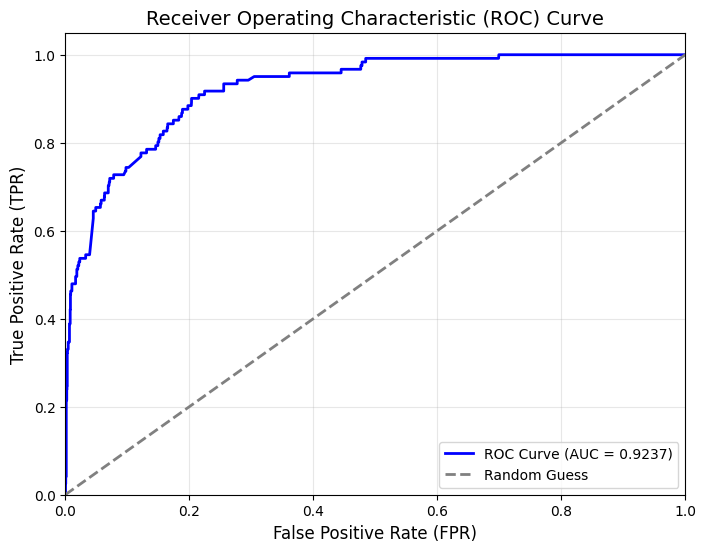

In [ ]:
evaluate_model(LogRmodel, X_train_cat, y_train_cat, X_val_cat, y_val_cat, X_test_cat, y_test_cat, scoring='roc_auc')

#### Count Vect

Cross-Validation ROC_AUC Scores: [0.98092787 0.97603948 0.97438263 0.97924615 0.9861676 ]
Cross-Validation Mean ROC_AUC: 0.9794
Validation AUC-ROC: 0.9592

Confusion Matrix Table:
                     Predicted Negative   Predicted Positive  
Actual Negative      2515                 9                   
Actual Positive      31                   90                  

Test Accuracy: 0.9849
Test Precision: 0.9091
Test Recall: 0.7438
Test F1 Score: 0.8182
Test AUC-ROC: 0.9685


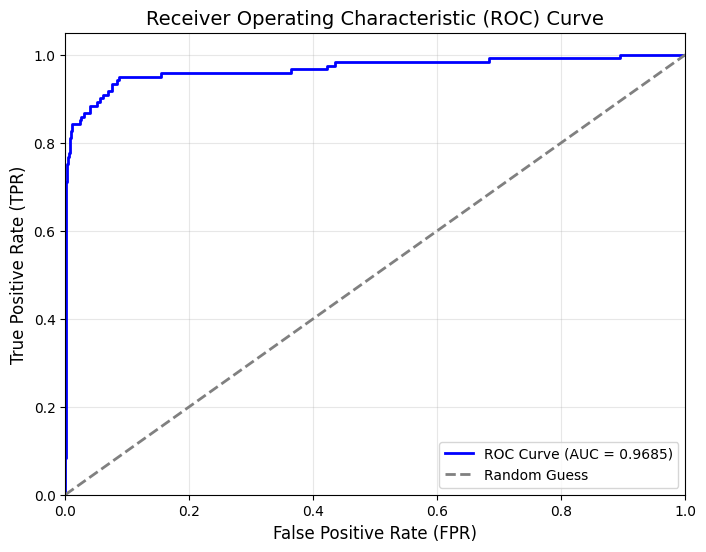

In [ ]:
evaluate_model(LogRmodel, X_train_count, y_train, X_val_count, y_val, X_test_count, y_test, scoring='roc_auc')

#### TF-IDF

Cross-Validation ROC_AUC Scores: [0.96960892 0.97374878 0.97504298 0.98235923 0.9847281 ]
Cross-Validation Mean ROC_AUC: 0.9771
Validation AUC-ROC: 0.9508

Confusion Matrix Table:
                     Predicted Negative   Predicted Positive  
Actual Negative      2523                 1                   
Actual Positive      70                   51                  

Test Accuracy: 0.9732
Test Precision: 0.9808
Test Recall: 0.4215
Test F1 Score: 0.5896
Test AUC-ROC: 0.9743


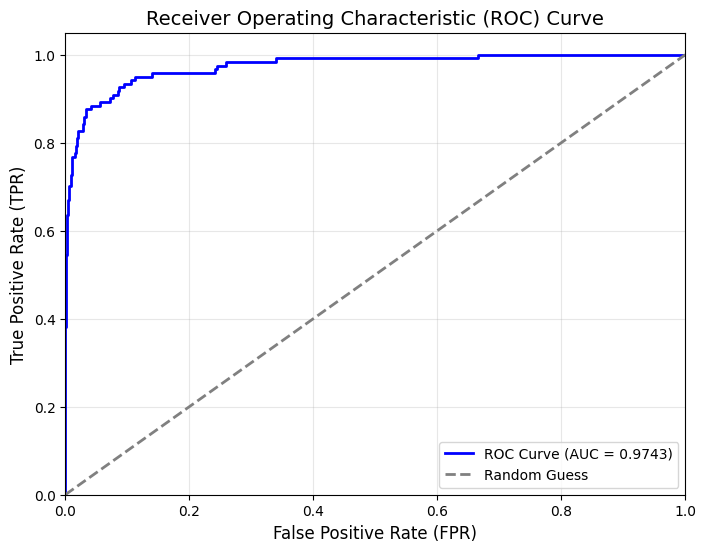

In [ ]:
evaluate_model(LogRmodel, X_train_tfidf, y_train, X_val_tfidf, y_val, X_test_tfidf, y_test, scoring='roc_auc')

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
RFmodel = RandomForestClassifier(n_estimators=100, random_state=42)

#### Categorical variables only

Cross-Validation ROC_AUC Scores: [0.94527719 0.93898107 0.96806738 0.96743148 0.94311559]
Cross-Validation Mean ROC_AUC: 0.9526
Validation AUC-ROC: 0.9539

Confusion Matrix Table:
                     Predicted Negative   Predicted Positive  
Actual Negative      2522                 2                   
Actual Positive      54                   67                  

Test Accuracy: 0.9788
Test Precision: 0.9710
Test Recall: 0.5537
Test F1 Score: 0.7053
Test AUC-ROC: 0.9569


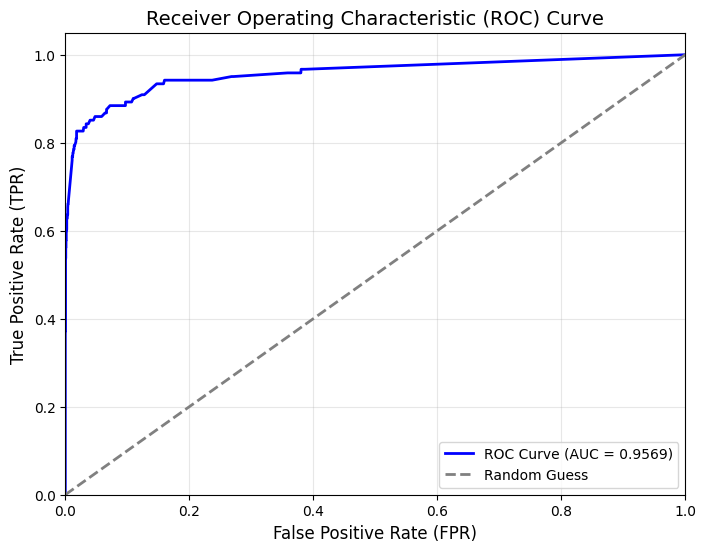

In [ ]:
evaluate_model(RFmodel, X_train_cat, y_train_cat, X_val_cat, y_val_cat, X_test_cat, y_test_cat, scoring='roc_auc')

#### Count Vect

In [ ]:
evaluate_model(RFmodel, X_train_count, y_train, X_val_count, y_val, X_test_count, y_test, scoring='roc_auc')

#### TF-IDF

In [ ]:
evaluate_model(RFmodel, X_train_tfidf, y_train, X_val_tfidf, y_val, X_test_tfidf, y_test, scoring='roc_auc')

# Decision Tree Classfier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
DTmodel = DecisionTreeClassifier(
    max_depth=5,              # Limit the depth of the tree to prevent overfitting
    min_samples_split=10,     # Minimum samples required to split an internal node
    min_samples_leaf=5,       # Minimum samples required to be a leaf node
    random_state=42           # Ensure reproducibility
)


#### Categorical variables only

In [ ]:
evaluate_model(DTmodel, X_train_cat, y_train_cat, X_val_cat, y_val_cat, X_test_cat, y_test_cat, scoring='roc_auc')

#### Count Vect

In [ ]:
evaluate_model(DTmodel, X_train_count, y_train, X_val_count, y_val, X_test_count, y_test, scoring='roc_auc')

#### TF-IDF

In [ ]:
evaluate_model(DTmodel, X_train_tfidf, y_train, X_val_tfidf, y_val, X_test_tfidf, y_test, scoring='roc_auc')

# Support Vector Machine (SVM)

In [ ]:
from sklearn.svm import SVC
SVMmodel = SVC(kernel='rbf', probability=True, random_state=42)

#### Categorical variables only

In [ ]:
evaluate_model(SVMmodel, X_train_cat, y_train_cat, X_val_cat, y_val_cat, X_test_cat, y_test_cat, scoring='roc_auc')

#### Count Vect

In [ ]:
evaluate_model(SVMmodel, X_train_count, y_train, X_val_count, y_val, X_test_count, y_test, scoring='roc_auc')

#### TF-IDF

In [ ]:
evaluate_model(SVMmodel, X_train_tfidf, y_train, X_val_tfidf, y_val, X_test_tfidf, y_test, scoring='roc_auc')

# Neural Network

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

nn_model_cat = Sequential([
    Input(shape=(X_train_cat.shape[1],)),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

nn_model_cat.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

nn_model_count = Sequential([
    Input(shape=(X_train_count.shape[1],)),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

nn_model_count.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

nn_model_tfidf = Sequential([
    Input(shape=(X_train_tfidf.shape[1],)),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

nn_model_tfidf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

For Neural Network we use a threshold probability of 0.5 to determine if prediction is fraud or not

#### Categorical Variables Only

Epoch 1/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9860 - loss: 0.0393 - val_accuracy: 0.9716 - val_loss: 0.1217
Epoch 2/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9885 - loss: 0.0347 - val_accuracy: 0.9735 - val_loss: 0.1199
Epoch 3/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9881 - loss: 0.0341 - val_accuracy: 0.9735 - val_loss: 0.1236
Epoch 4/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9883 - loss: 0.0350 - val_accuracy: 0.9747 - val_loss: 0.1201
Epoch 5/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9883 - loss: 0.0342 - val_accuracy: 0.9705 - val_loss: 0.1276
Epoch 6/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9863 - loss: 0.0376 - val_accuracy: 0.9599 - val_loss: 0.1343
Epoch 7/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9885 - loss: 0.0334 - val_accuracy: 0.9720 - val_loss: 0.1279
Epoch 8/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9874 - loss: 0.0376 - val_accuracy

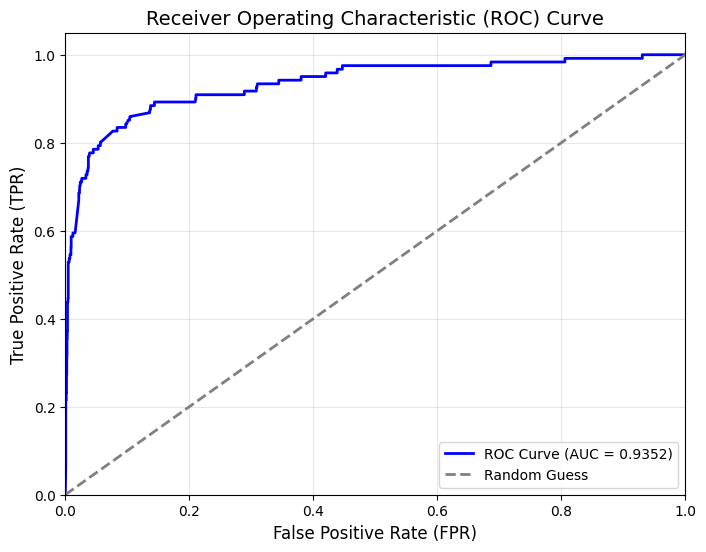

In [ ]:
evaluate_keras_nn_model(nn_model,  X_train_cat, y_train_cat, X_val_cat, y_val_cat, X_test_cat, y_test_cat, epochs=20, batch_size=32)

#### Count Vectorizer

Epoch 1/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.9520 - loss: 0.1616 - val_accuracy: 0.9811 - val_loss: 0.0801
Epoch 2/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9928 - loss: 0.0322 - val_accuracy: 0.9849 - val_loss: 0.0757
Epoch 3/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.9978 - loss: 0.0082 - val_accuracy: 0.9856 - val_loss: 0.0912
Epoch 4/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.9996 - loss: 0.0031 - val_accuracy: 0.9856 - val_loss: 0.1035
Epoch 5/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.9999 - loss: 0.0013 - val_accuracy: 0.9849 - val_loss: 0.1129
Epoch 6/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.9994 - loss: 0.0024 - val_accuracy: 0.9853 - val_loss: 0.1232
Epoch 7/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.9999 - loss: 5.9654e-04 - val_accuracy: 0.9849 - val_loss: 0.1284
Epoch 8/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.9999 - loss: 4.7538

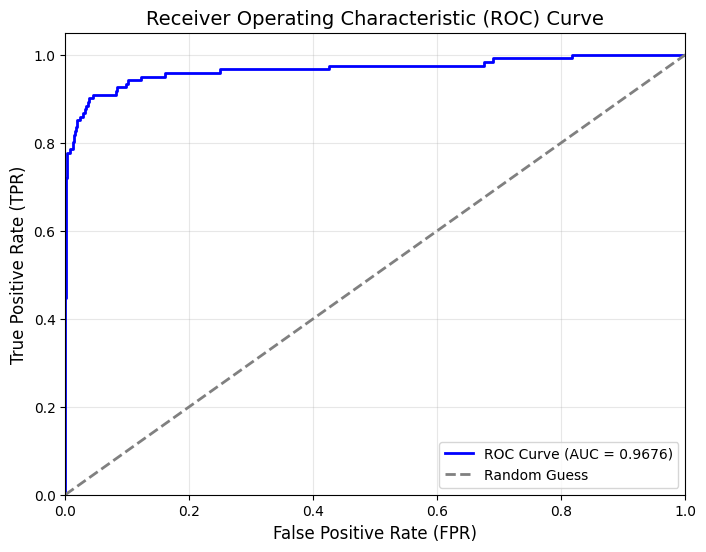

In [ ]:
evaluate_keras_nn_model(nn_model_count,  X_train_count, y_train, X_val_count, y_val, X_test_count, y_test, epochs=20, batch_size=32)

#### TF-IDF

Epoch 1/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.9345 - loss: 0.4547 - val_accuracy: 0.9716 - val_loss: 0.0916
Epoch 2/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.9825 - loss: 0.0598 - val_accuracy: 0.9841 - val_loss: 0.0562
Epoch 3/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - accuracy: 0.9968 - loss: 0.0153 - val_accuracy: 0.9856 - val_loss: 0.0549
Epoch 4/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.9987 - loss: 0.0079 - val_accuracy: 0.9841 - val_loss: 0.0567
Epoch 5/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.9992 - loss: 0.0037 - val_accuracy: 0.9849 - val_loss: 0.0623
Epoch 6/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.9996 - loss: 0.0031 - val_accuracy: 0.9849 - val_loss: 0.0650
Epoch 7/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.9997 - loss: 0.0019 - val_accuracy: 0.9849 - val_loss: 0.0692
Epoch 8/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 1.0000 - loss: 7.9122e-04 -

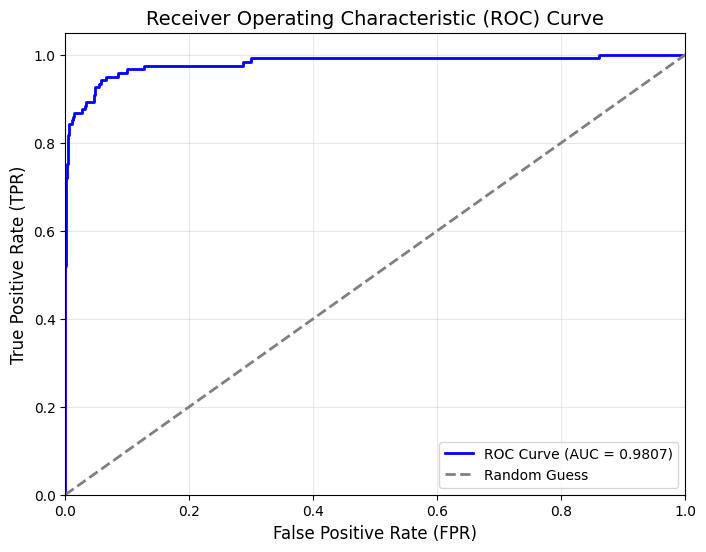

In [ ]:
evaluate_keras_nn_model(nn_model_tfidf, X_train_tfidf, y_train, X_val_tfidf, y_val, X_test_tfidf, y_test, epochs=20, batch_size=32)

# XGBOOST

In [ ]:
from xgboost import XGBClassifier
XGBmodel = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    use_label_encoder=False,  # Disable label encoder to avoid warnings
    eval_metric='logloss',   # Default metric
    random_state=42
)

#### Categorical variables only

In [ ]:
evaluate_model(XGBmodel, X_train_cat, y_train_cat, X_val_cat, y_val_cat, X_test_cat, y_test_cat, scoring='roc_auc')

#### Count Vect

In [ ]:
evaluate_model(XGBmodel, X_train_count, y_train, X_val_count, y_val, X_test_count, y_test, scoring='roc_auc')

#### TF-IDF

In [ ]:
evaluate_model(XGBmodel, X_train_tfidf, y_train, X_val_tfidf, y_val, X_test_tfidf, y_test, scoring='roc_auc')